In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [57]:
#Функция для поиска Единственного наиболее частого значения. Если таких нет или несколько, то выводит np.nan
def aggGroupedVals(vals):
    most_freq_cabin = pd.Series.mode(vals)
    if most_freq_cabin.shape[0] != 1:
        return np.nan
    else:
        return most_freq_cabin[0]

#Обучение модели
def train_model(model, df):
    X = df.drop('Transported', axis=1)
    y = df['Transported']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print('Параметры модели')
    for param_name, param_val in grid_model.best_estimator_['model'].get_params().items():
        print(f'{param_name} = {param_val}')
    print(classification_report(y_test, y_predict))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [3]:
#Загрузка данных
df_train_origin = pd.read_csv('train.csv', index_col='PassengerId')
df_test_origin = pd.read_csv('test.csv', index_col='PassengerId')
df_full = pd.concat([df_train_origin, df_test_origin], axis=0)

In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0001_01 to 9277_01
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12682 non-null  object 
 1   CryoSleep     12660 non-null  object 
 2   Cabin         12671 non-null  object 
 3   Destination   12696 non-null  object 
 4   Age           12700 non-null  float64
 5   VIP           12674 non-null  object 
 6   RoomService   12707 non-null  float64
 7   FoodCourt     12681 non-null  float64
 8   ShoppingMall  12664 non-null  float64
 9   Spa           12686 non-null  float64
 10  VRDeck        12702 non-null  float64
 11  Name          12676 non-null  object 
 12  Transported   8693 non-null   object 
dtypes: float64(6), object(7)
memory usage: 1.4+ MB


In [5]:
#Работаем с пропусками

In [6]:
#Cabin

In [7]:
#На основании индекса PassengerID создадим 2 признака: PassengerGroup(группа пассажира) и
#PassengerNo(номер пассажира в группе)
pass_group_no = np.array([pairs for pairs in df_full.index.str.split('_').values])
df_full['PassengerGroup'] = pass_group_no[:, 0].astype(np.int16)
df_full['PassengerNo'] = pass_group_no[:, 1].astype(np.int16)
#На основании признака Name создадим признак Surname(только фамилия пассажира)
pass_surname = df_full['Name'].str.split(' ').values
df_full['Surname'] = [np.nan if full_name is np.nan else full_name[-1] for full_name in pass_surname]

In [8]:
#Предполагаем, что люди из одной PassengerGroup и одинаковым Surname будут жить в одной Cabin
pass_pairs_cabin = df_full.groupby(by=['PassengerGroup','Surname'])['Cabin'].agg(aggGroupedVals)
pass_pairs_cabin.name = 'CabinFillNA'
pass_pairs_cabin = df_full.merge(pass_pairs_cabin, 
                                 how='left', 
                                 left_on=['PassengerGroup','Surname'], 
                                 right_index=True)['CabinFillNA']
df_full['Cabin'] = df_full['Cabin'].fillna(pass_pairs_cabin)

In [9]:
#Далее для удобства создадим на основании Cabin 3 признака: CabinDeck(палуба), CabinNo(номер каюты) и 
#CabinSide(P-левый борт, S-правый борт)
pass_cabin_info = df_full['Cabin'].str.split('/').values
df_full['CabinDeck'] = [np.nan if info is np.nan else info[0] for info in pass_cabin_info]
df_full['CabinNo'] = [np.nan if info is np.nan else info[1] for info in pass_cabin_info]
df_full['CabinSide'] = [np.nan if info is np.nan else info[2] for info in pass_cabin_info]
#Удалим Cabin
df_full = df_full.drop('Cabin', axis=1)

In [10]:
#Исследуем влияение HomePlanet, CryoSleep, Destination, VIP на CabinDeck, CabinSide
for grouped_col in ['HomePlanet','CryoSleep','Destination','VIP']:
    print(f'Ситуация по признаку {grouped_col}')
    print(df_full.groupby(by=grouped_col)['CabinDeck'].value_counts())
#Пассажиры достаточно равномерно распределены по палубам и бортам в зависимости от 'CryoSleep', 'Destination', 'VIP'

Ситуация по признаку HomePlanet
HomePlanet  CabinDeck
Earth       G            3733
            F            2436
            E             586
Europa      B            1142
            C            1100
            A             353
            D             299
            E             198
            T              10
Mars        F            1726
            E             513
            D             412
Name: count, dtype: int64
Ситуация по признаку CryoSleep
CryoSleep  CabinDeck
False      F            3299
           G            1694
           E            1044
           C             621
           D             544
           B             516
           A             245
           T              10
True       G            2029
           F             861
           B             617
           C             471
           E             257
           D             171
           A             106
Name: count, dtype: int64
Ситуация по признаку Destination
Destination   

In [11]:
#Возьмем самые частые палубы в зависимости от HomePlanet
pass_home_cabin = df_full.groupby(by='HomePlanet')['CabinDeck'].agg(aggGroupedVals)
pass_home_cabin.name = 'CabinFillNA'
pass_home_cabin = df_full.merge(pass_home_cabin, 
                                how='left', 
                                left_on='HomePlanet', 
                                right_index=True)['CabinFillNA']
df_full['CabinDeck'] = df_full['CabinDeck'].fillna(pass_home_cabin)

In [12]:
#Остальное заполним самой частой палубой по всей выборке
df_full['CabinDeck'] = df_full['CabinDeck'].fillna('F')

In [13]:
#Видим, что на левом борту людей переносило меньше
#Удалим CabinNo, а NaN значения для СabinSide заменим на Unknown
df_full = df_full.drop('CabinNo', axis=1)
df_full['CabinSide'] = df_full['CabinSide'].fillna('Unknown')

In [14]:
df_full.groupby(by='Transported')['CabinSide'].value_counts()

Transported  CabinSide
False        P            2325
             S            1925
             Unknown        65
True         S            2411
             P            1918
             Unknown        49
Name: count, dtype: int64

In [15]:
#HomePlanet

In [16]:
#Зависимость HomePlanet от VIP
df_full.groupby(by='VIP')['HomePlanet'].value_counts()

VIP    HomePlanet
False  Earth         6706
       Europa        2883
       Mars          2533
True   Europa         177
       Mars            90
Name: count, dtype: int64

In [17]:
#Зависимость HomePlanet от CabinDeck
df_full.groupby(by='CabinDeck')['HomePlanet'].value_counts()

CabinDeck  HomePlanet
A          Europa         353
B          Europa        1173
C          Europa        1100
D          Mars           412
           Europa         299
E          Earth          586
           Mars           513
           Europa         198
F          Earth         2436
           Mars          1759
G          Earth         3843
T          Europa          10
Name: count, dtype: int64

In [18]:
#Для каждой PassengerGroup найдем самую распространенную HomePlanet
most_freq_home_for_pass_group = df_full.groupby(by='PassengerGroup')['HomePlanet'].agg(pd.Series.mode)
most_freq_home_for_pass_group = most_freq_home_for_pass_group.where(most_freq_home_for_pass_group.str.len() > 0)
most_freq_home_for_pass_group.name = 'HomeFillPassGroup'
most_freq_home_for_pass_group = df_full.merge(most_freq_home_for_pass_group, 
                                              how='left', 
                                              left_on='PassengerGroup', 
                                              right_index=True)['HomeFillPassGroup']
df_full['HomePlanet'] = df_full['HomePlanet'].fillna(most_freq_home_for_pass_group)

In [19]:
#Для каждой CabinDeck найдем самую распространенную HomePlanet
most_freq_home_for_deck = df_full.groupby(by='CabinDeck')['HomePlanet'].agg(pd.Series.mode)
most_freq_home_for_deck.name = 'HomeFillDeck'
most_freq_home_for_deck = df_full.merge(most_freq_home_for_deck, 
                                        how='left', 
                                        left_on='CabinDeck', 
                                        right_index=True)['HomeFillDeck']
df_full['HomePlanet'] = df_full['HomePlanet'].fillna(most_freq_home_for_deck)

In [20]:
#ЗАМЕЧАНИЕ! С Earth нет VIP пассажиров. Заменим на Mars - единственная планета, которая подходит
df_full.loc[df_full['VIP'] & (df_full['HomePlanet'] == 'Earth'), 'HomePlanet'] = 'Mars'

In [21]:
#Остальные 5 пропусков заменим на Earth, т.к. самая распространенная HomePlanet(по VIP подходит)
df_full['HomePlanet'] = df_full['HomePlanet'].fillna('Earth')

In [22]:
#CryoSleep

In [23]:
#Исследуем влияение HomePlanet, Destination, VIP, CabinDeck на CryoSleep
for grouped_col in ['HomePlanet','Destination','VIP','CabinDeck']:
    print(f'Ситуация по признаку {grouped_col}')
    print(df_full.groupby(by=grouped_col)['CryoSleep'].value_counts())

Ситуация по признаку HomePlanet
HomePlanet  CryoSleep
Earth       False        4756
            True         2124
Europa      False        1705
            True         1401
Mars        False        1618
            True         1056
Name: count, dtype: int64
Ситуация по признаку Destination
Destination    CryoSleep
55 Cancri e    False        1475
               True         1103
PSO J318.5-22  False         583
               True          575
TRAPPIST-1e    False        5834
               True         2823
Name: count, dtype: int64
Ситуация по признаку VIP
VIP    CryoSleep
False  False        7657
       True         4449
True   False         239
       True           28
Name: count, dtype: int64
Ситуация по признаку CabinDeck
CabinDeck  CryoSleep
A          False         245
           True          106
B          True          632
           False         530
C          False         621
           True          471
D          False         544
           True          171
E     

In [24]:
#Можно в зависимости от палубы находить CryoSleep
pass_cabin_sleep = df_full.groupby(by='CabinDeck')['CryoSleep'].agg(aggGroupedVals)
pass_cabin_sleep.name = 'CryoSleepFillNA'
pass_cabin_sleep = df_full.merge(pass_cabin_sleep, 
                                 how='left', 
                                 left_on='CabinDeck', 
                                 right_index=True)['CryoSleepFillNA'].astype(np.float16)
df_full['CryoSleep'] = df_full['CryoSleep'].fillna(pass_cabin_sleep)

In [25]:
#Destination

In [26]:
#Исследуем влияение HomePlanet, CryoSleep, VIP, CabinDeck на Destination
for grouped_col in ['HomePlanet','CryoSleep','VIP','CabinDeck']:
    print(f'Ситуация по признаку {grouped_col}')
    print(df_full.groupby(by=grouped_col)['Destination'].value_counts())

Ситуация по признаку HomePlanet
HomePlanet  Destination  
Earth       TRAPPIST-1e      4804
            PSO J318.5-22    1087
            55 Cancri e      1006
Europa      TRAPPIST-1e      1765
            55 Cancri e      1336
            PSO J318.5-22      29
Mars        TRAPPIST-1e      2302
            55 Cancri e       299
            PSO J318.5-22      68
Name: count, dtype: int64
Ситуация по признаку CryoSleep
CryoSleep  Destination  
False      TRAPPIST-1e      5965
           55 Cancri e      1512
           PSO J318.5-22     599
True       TRAPPIST-1e      2906
           55 Cancri e      1129
           PSO J318.5-22     585
Name: count, dtype: int64
Ситуация по признаку VIP
VIP    Destination  
False  TRAPPIST-1e      8510
       55 Cancri e      2491
       PSO J318.5-22    1136
True   TRAPPIST-1e       163
       55 Cancri e        85
       PSO J318.5-22      22
Name: count, dtype: int64
Ситуация по признаку CabinDeck
CabinDeck  Destination  
A          TRAPPIST-1e      

In [27]:
#Большинство летит на TRAPPIST-1e
df_full['Destination'] = df_full['Destination'].fillna('TRAPPIST-1e')

In [28]:
#RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

In [29]:
#Заменяем нулями
df_full['RoomService'] = df_full['RoomService'].fillna(0)
df_full['FoodCourt'] = df_full['FoodCourt'].fillna(0)
df_full['ShoppingMall'] = df_full['ShoppingMall'].fillna(0)
df_full['Spa'] = df_full['Spa'].fillna(0)
df_full['VRDeck'] = df_full['VRDeck'].fillna(0)

In [30]:
#Создадим признак со всеми затратами на развлечение
df_full['AllSpending'] = np.sum(df_full[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']], axis=1)

In [31]:
#VIP

<Axes: xlabel='AllSpending', ylabel='VIP'>

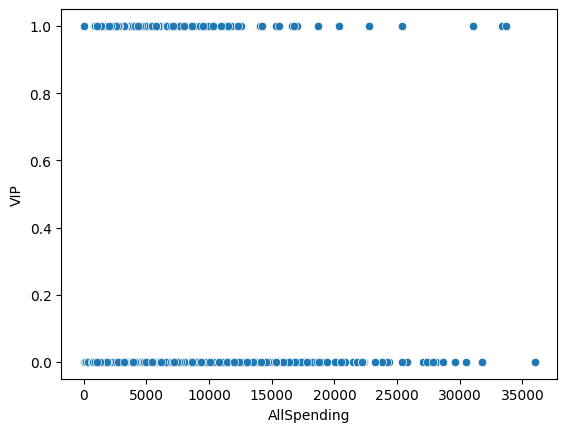

In [32]:
#Основная масса VIP пассажиров не тратит много денег на доп. развлечения, однако многие и без VIP не тратят
sns.scatterplot(data=df_full[df_full['AllSpending']>0], x='AllSpending', y='VIP')

In [33]:
#Заменим Nan на False
df_full['VIP'] = df_full['VIP'].fillna(0)

In [34]:
#Age

In [35]:
df_full.groupby(by='CabinDeck')['Age'].mean()

CabinDeck
A    35.484330
B    33.607204
C    34.690064
D    33.446779
E    30.214559
F    28.417971
G    24.007035
T    35.545455
Name: Age, dtype: float64

In [36]:
#Можно в зависимости от палубы находить средний возраст
pass_cabin_age = df_full.groupby(by='CabinDeck')['Age'].mean()
pass_cabin_age.name = 'AgeFillNA'
pass_cabin_age = df_full.merge(pass_cabin_age, 
                               how='left', 
                               left_on='CabinDeck', 
                               right_index=True)['AgeFillNA']
df_full['Age'] = df_full['Age'].fillna(pass_cabin_age)

In [37]:
#Работа с признаками

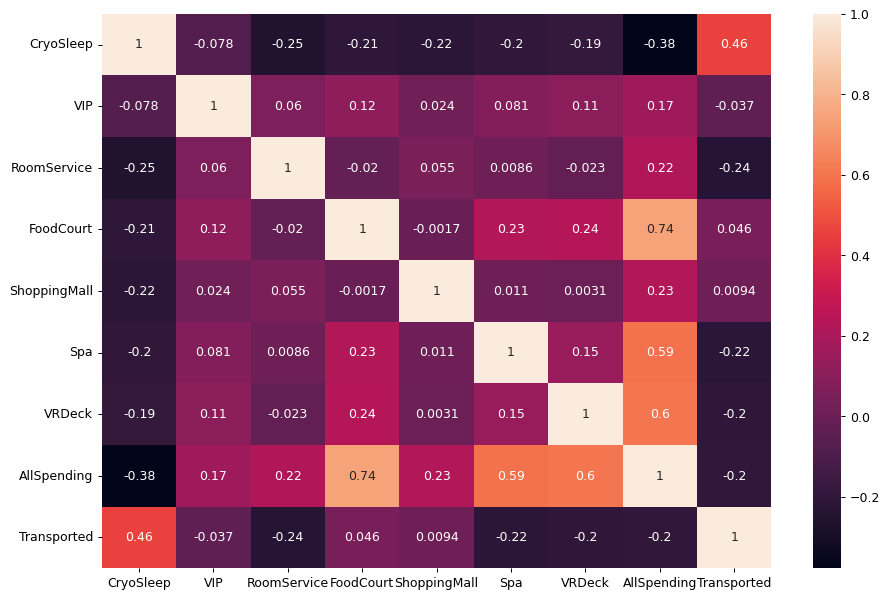

In [38]:
#Оставим затраты на развлечения в раздельном виде (удалим AllSpending)
plt.figure(figsize=(12,8),dpi=90)
sns.heatmap(df_full[['CryoSleep','VIP','RoomService','FoodCourt','ShoppingMall',
                     'Spa','VRDeck','AllSpending','Transported']].corr(),
            annot=True)
df_full = df_full.drop('AllSpending', axis=1)

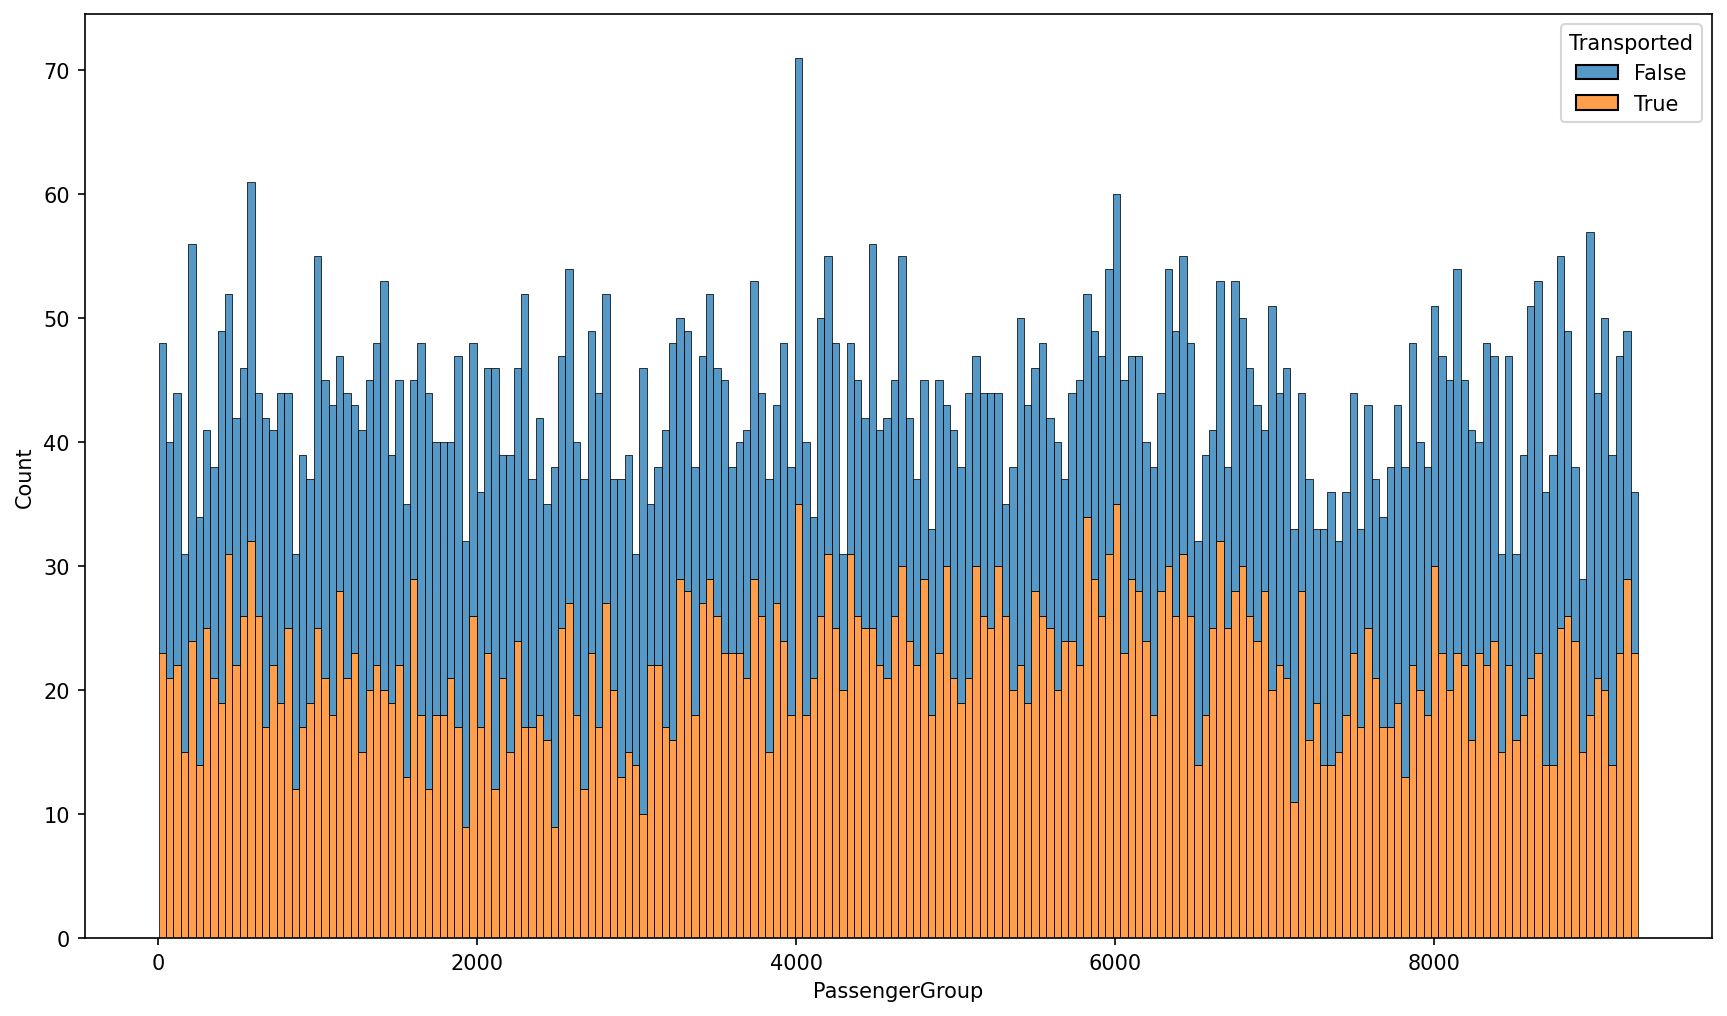

In [39]:
#В целом Перемещенные пассажиры в каждой группе составляют половину от всех пассажиров. Выделять 
#значения PassengerGroup в отдельные кластеры с преобладанием какого-либо значения Transported не имеет смысла
#Удаляем 
plt.figure(figsize=(14,8),dpi=150)
sns.histplot(df_full, x='PassengerGroup', bins=200, hue='Transported', multiple='stack')
df_full = df_full.drop(['PassengerGroup','PassengerNo'], axis=1)

In [40]:
#Людей с VIP статусом всего 2% от всех, можно удалить признак
#Удаляем VIP, Name, Surname
df_full = df_full.drop(['VIP','Name','Surname'], axis=1)

In [41]:
#Приведем Transported к типу Int
df_full['Transported'] = df_full['Transported'].astype(np.float64)

In [42]:
#Создаем Dummy-переменные
df_dummy = pd.get_dummies(df_full)

In [43]:
#Из-за малого кол-ва пассажиров на палубе T можно удалить CabinDeck_T
df_dummy['CabinDeck_T'].value_counts()
df_dummy = df_dummy.drop('CabinDeck_T', axis=1)

In [44]:
#Из-за малого кол-ва Unknown значения борта можно удалить CabinSide_Unknown
df_dummy['CabinSide_Unknown'].value_counts()
df_dummy = df_dummy.drop('CabinSide_Unknown', axis=1)

In [45]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0001_01 to 9277_01
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        12970 non-null  float64
 1   RoomService                12970 non-null  float64
 2   FoodCourt                  12970 non-null  float64
 3   ShoppingMall               12970 non-null  float64
 4   Spa                        12970 non-null  float64
 5   VRDeck                     12970 non-null  float64
 6   Transported                8693 non-null   float64
 7   HomePlanet_Earth           12970 non-null  bool   
 8   HomePlanet_Europa          12970 non-null  bool   
 9   HomePlanet_Mars            12970 non-null  bool   
 10  CryoSleep_False            12970 non-null  bool   
 11  CryoSleep_True             12970 non-null  bool   
 12  Destination_55 Cancri e    12970 non-null  bool   
 13  Destination_PSO J318.5-22  12970 non-null  

In [46]:
#Обучение

In [47]:
#Разделение на Training и Resulting
df_training = df_dummy.dropna().astype({'Transported': bool})
df_resulting = df_dummy[df_dummy['Transported'].isna()].drop('Transported', axis=1)

In [48]:
#SVC
scaler = StandardScaler()
elNet = SVC()
pipe_model = Pipeline([('scaler', scaler), ('model', elNet)])
grid_params = {'model__C': [0.1,1,10,20,50]}
grid_model = GridSearchCV(pipe_model, grid_params, scoring='accuracy', cv=5, verbose=2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .......................................model__C=0.1; total time=   1.1s
[CV] END .......................................model__C=0.1; total time=   1.1s
[CV] END .......................................model__C=0.1; total time=   1.1s
[CV] END .......................................model__C=0.1; total time=   1.1s
[CV] END .......................................model__C=0.1; total time=   1.1s
[CV] END .........................................model__C=1; total time=   1.1s
[CV] END .........................................model__C=1; total time=   1.0s
[CV] END .........................................model__C=1; total time=   1.0s
[CV] END .........................................model__C=1; total time=   1.0s
[CV] END .........................................model__C=1; total time=   1.1s
[CV] END ........................................model__C=10; total time=   1.2s
[CV] END ........................................

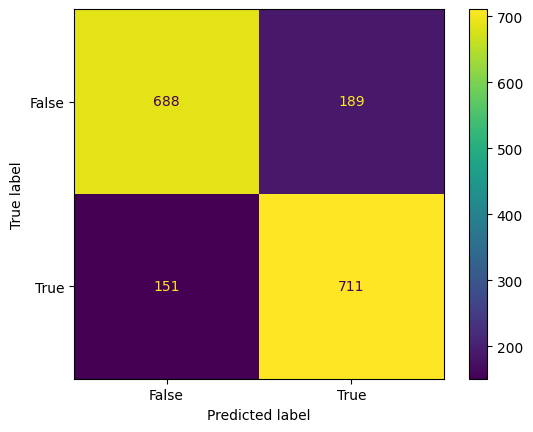

In [58]:
train_model(grid_model, df_training)